# Deep Video Analytics tutorial

##### This tutorial uses REST API endpoint wrapped in a DVA python client.

##### Install DVA Client  

In [3]:
!cd ../../client && python setup.py install

running install
running build
running build_py
creating build
creating build/lib.linux-x86_64-2.7
creating build/lib.linux-x86_64-2.7/dvaclient
copying dvaclient/utils.py -> build/lib.linux-x86_64-2.7/dvaclient
copying dvaclient/query.py -> build/lib.linux-x86_64-2.7/dvaclient
copying dvaclient/__init__.py -> build/lib.linux-x86_64-2.7/dvaclient
copying dvaclient/context.py -> build/lib.linux-x86_64-2.7/dvaclient
copying dvaclient/constants.py -> build/lib.linux-x86_64-2.7/dvaclient
copying dvaclient/visual_search_results.py -> build/lib.linux-x86_64-2.7/dvaclient
running install_lib
creating /usr/local/lib/python2.7/dist-packages/dvaclient
copying build/lib.linux-x86_64-2.7/dvaclient/utils.py -> /usr/local/lib/python2.7/dist-packages/dvaclient
copying build/lib.linux-x86_64-2.7/dvaclient/query.py -> /usr/local/lib/python2.7/dist-packages/dvaclient
copying build/lib.linux-x86_64-2.7/dvaclient/__init__.py -> /usr/local/lib/python2.7/dist-packages/dvaclient
copying build/lib.linux-x86_64

In [8]:
import dvaclient
import logging, json

## Using Deep Video Analytics python client

####  Following command generate & copy a REST API token, it can also be found at /security page from the sidebar in DVA UI

In [ ]:
!cd ../../server/scripts/ && python generate_testing_token.py

In [10]:
ctx = dvaclient.context.DVAContext(server='http://localhost/', 
                                   token=json.load(file('../../server/scripts/creds.json'))['token'])

## REST API vs DVAPQL

Deep Video Analytics uses REST API (GET, LIST, but **NOT POST**) for exposing state of the system along metadata and urls to raw contents such as videos and images. **/queries is the only endpoint that supports POST requests** for mutating the state of the system. The user submits a DVAPQL query for loading videos/datasets, launching processing jobs, importing models and performing visual search. 

### List videos

In [11]:
for v in ctx.list_videos():
    print "{name} with ID: {vid}".format(name=v['name'],vid=v['id'])

crnn_test with ID: 3
crnn_test with ID: 4
exampledataset with ID: 2
citest with ID: 1


### List configured indexing, detection and analysis models

In [16]:
for v in ctx.list_models():
    print v['name'], v['model_type']

coco D
textbox D
face D
inception I
facenet I
crnn A
tagger A


## Process a video

In [12]:
video_processing_query = dvaclient.query.ProcessVideoURL(name="spectre",url="https://www.youtube.com/watch?v=ashLaclKCik")
video_processing_query.execute(ctx)

### Monitor tasks state for a query

In [25]:
for e in ctx.list_events():
    if int(e['parent_process'].strip('/').split('/')[-1]) == video_processing_query.query_id:
        print e['created'],e['start_ts'],e['operation'],e['started'],e['completed'],e['duration']

2017-11-26T10:31:43.419589Z 2017-11-26T10:32:06.593145Z perform_detection True True 33.101476
2017-11-26T10:31:43.427465Z 2017-11-26T10:32:59.364413Z perform_detection True True 76.400455
2017-11-26T10:31:07.440117Z 2017-11-26T10:31:07.489031Z perform_import True True 4.466136
2017-11-26T10:31:41.352440Z 2017-11-26T10:31:41.366231Z perform_indexing True True 17.570143
2017-11-26T10:31:11.948071Z 2017-11-26T10:31:11.964124Z perform_video_segmentation True True 21.774941
2017-11-26T10:31:33.733353Z 2017-11-26T10:31:33.755997Z perform_video_decode True True 7.610575
2017-11-26T10:31:33.679197Z 2017-11-26T10:31:33.741824Z perform_video_decode True True 9.689847
2017-11-26T10:31:41.357809Z 2017-11-26T10:31:41.373379Z perform_detection True True 25.109872
2017-11-26T10:31:43.407422Z 2017-11-26T10:31:59.010065Z perform_indexing True True 24.653178
2017-11-26T10:31:41.363116Z 2017-11-26T10:31:41.376549Z perform_detection True True 77.729756
2017-11-26T10:32:39.691163Z 2017-11-26T10:33:02.65142

##### Optionally you can "wait" on it to complete,

In [13]:
video_processing_query.wait()

## Finding similar images

### Query image

In [4]:
leo_query_image = 'figures/query_leo.png'

### Get configured retrievers and indexers

In [5]:
indexers = {r['name']:r for r in ctx.list_models() if r['model_type'] == 'I'}
retrievers = {r['name']:r for r in ctx.list_retrievers()}

### Make a query using inception retriever and inception indexer

In [10]:
inception_indexer_pk = indexers['inception']['id']
inception_retriever_pk = retrievers['inception']['id']
q = dvaclient.query.FindSimilarImages(leo_query_image,indexer_pk=inception_indexer_pk,retriever_pk=inception_retriever_pk)
q.execute(context=ctx)
q.wait()
q.gather_search_results()

### Visualize results

Query Image


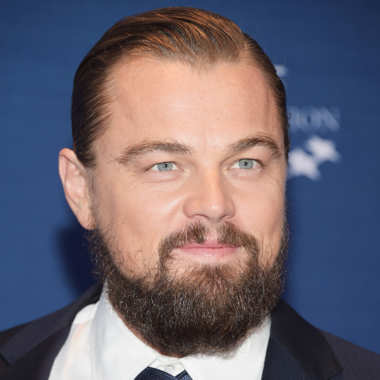

Task ID 21 operation: perform_retrieval with retriever 1 and max_results 20
Results
Rank 1, region


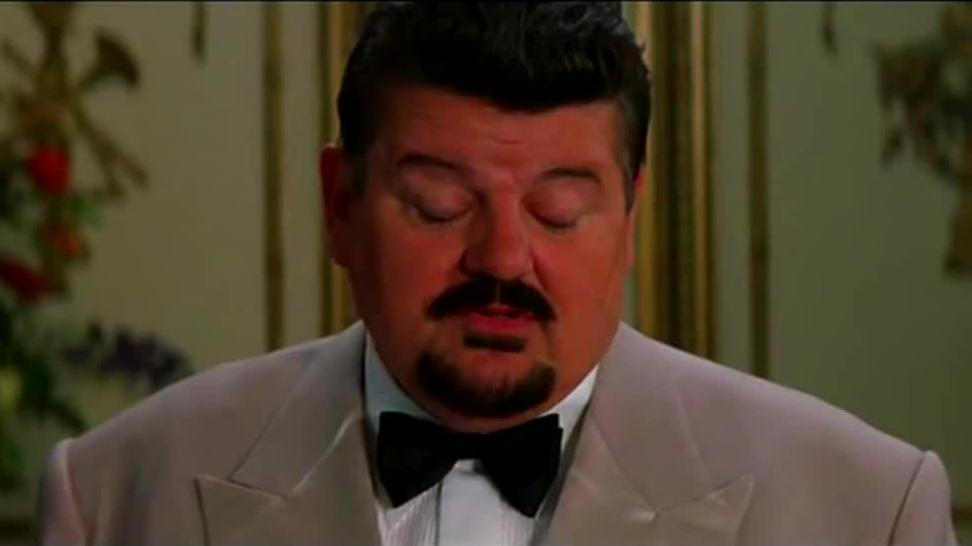

Rank 2, region


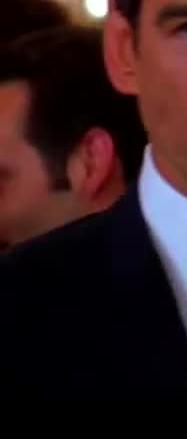

Rank 3, region


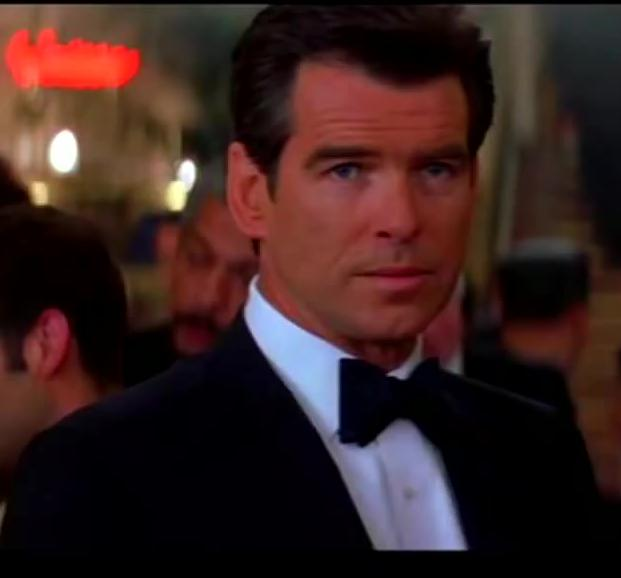

Rank 4, region


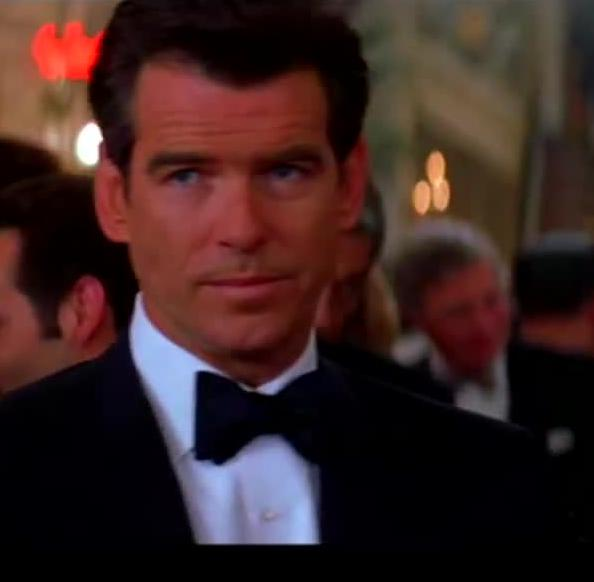

Rank 5, region


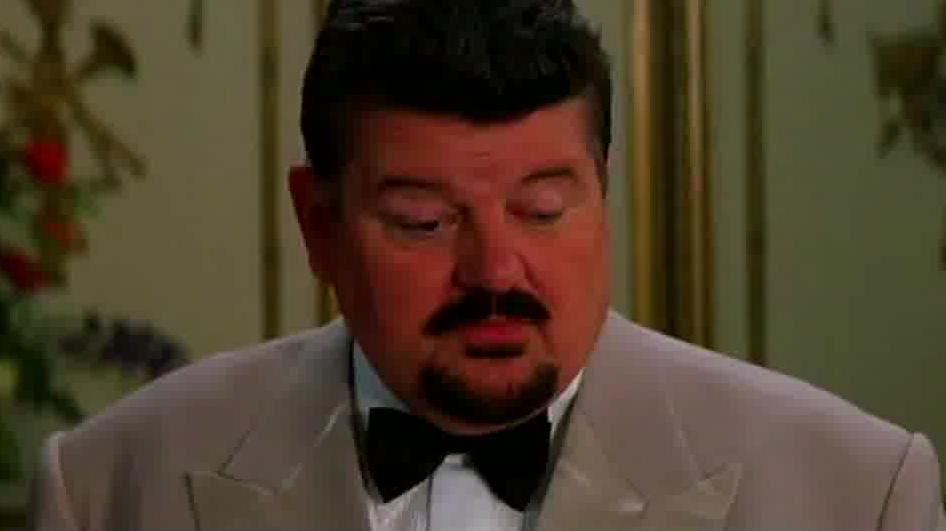

Rank 6, region


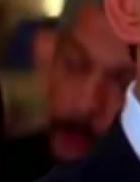

Rank 7, full frame


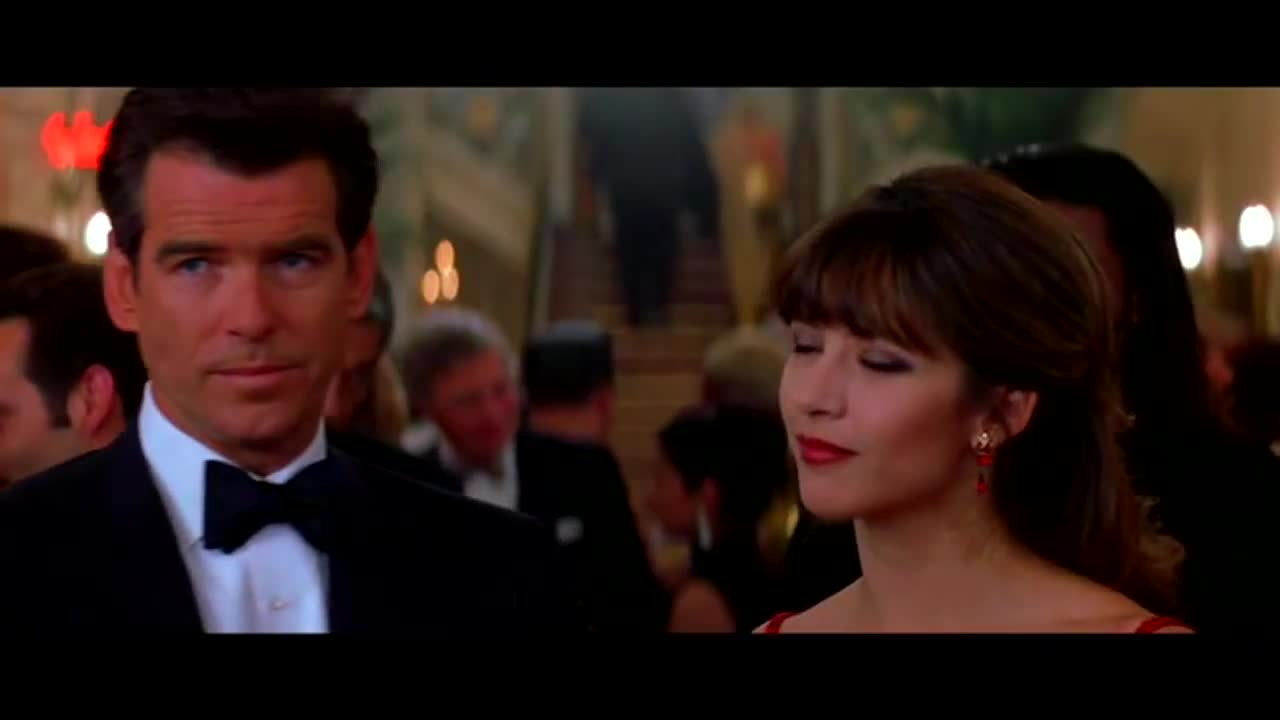

Rank 8, full frame


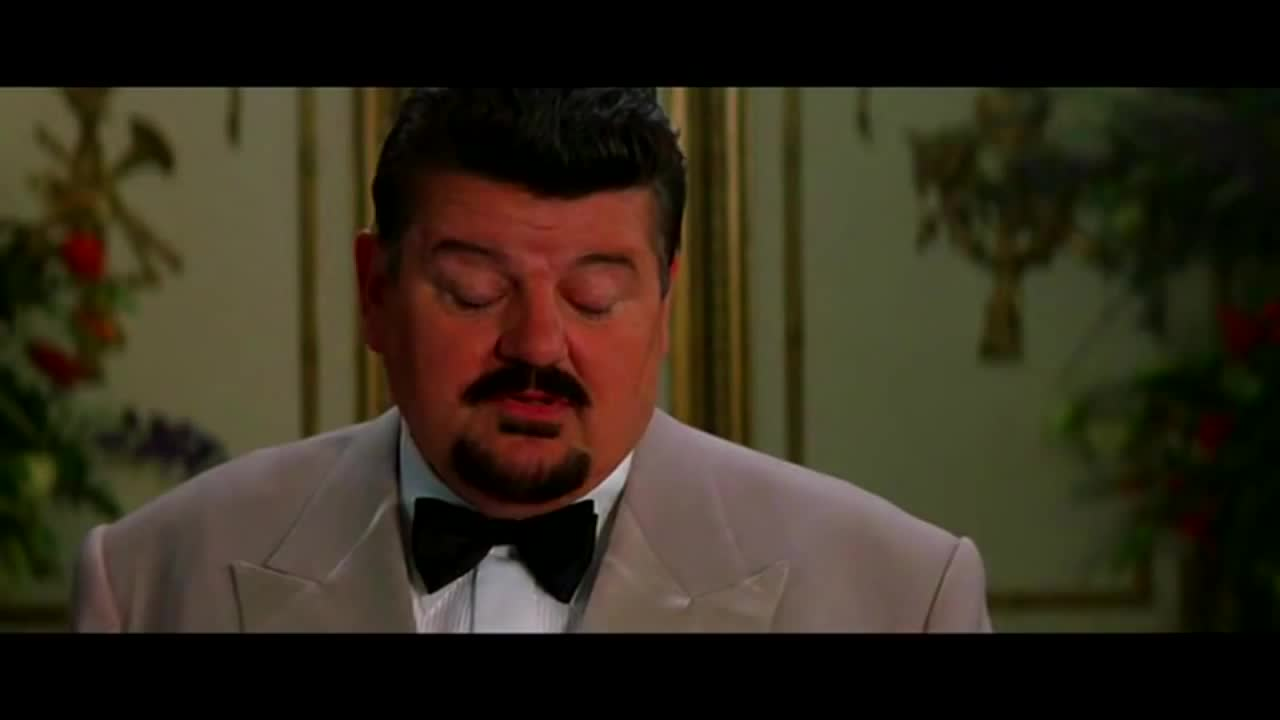

Rank 9, full frame


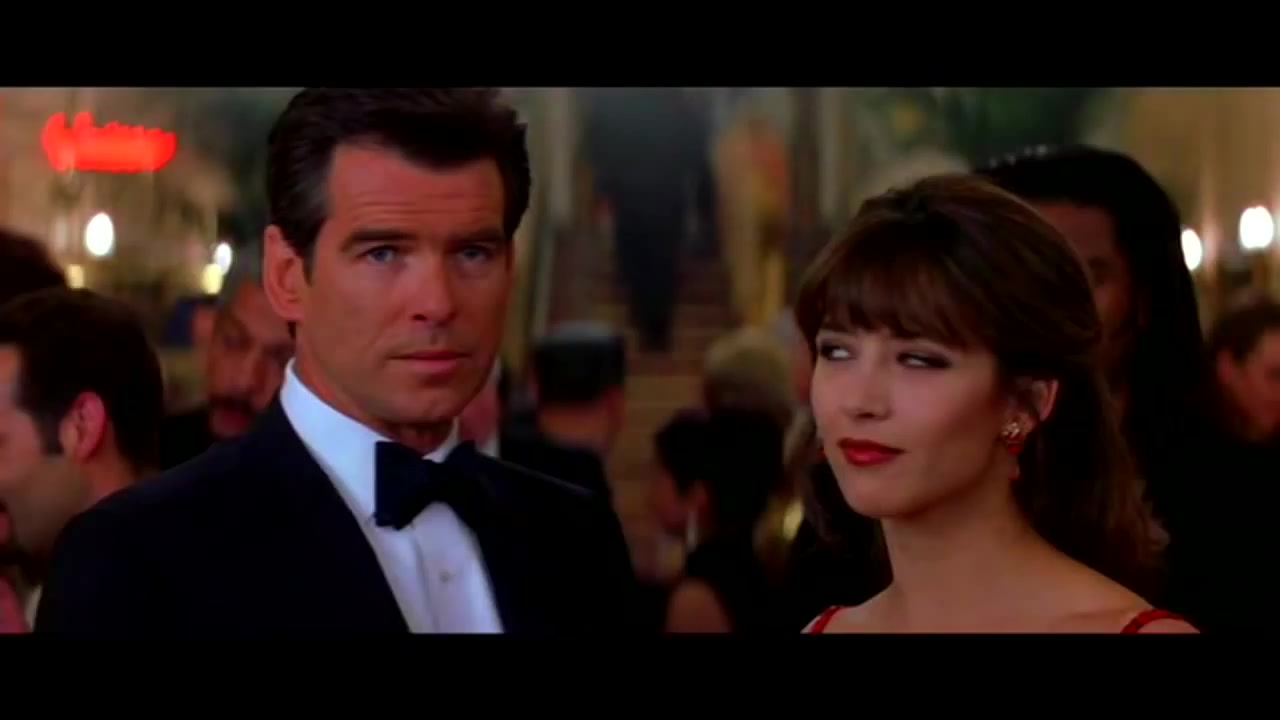

Rank 10, region


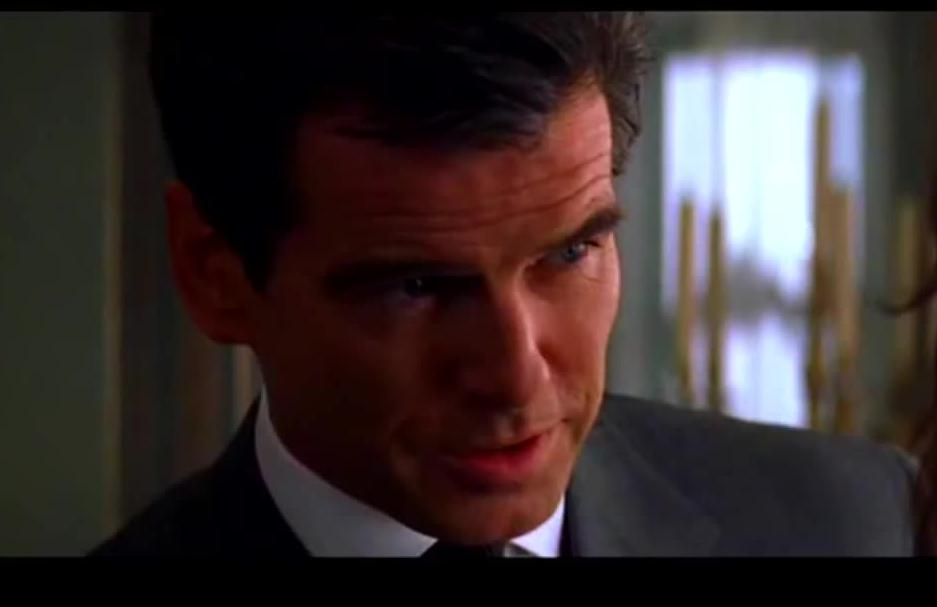

Rank 11, full frame


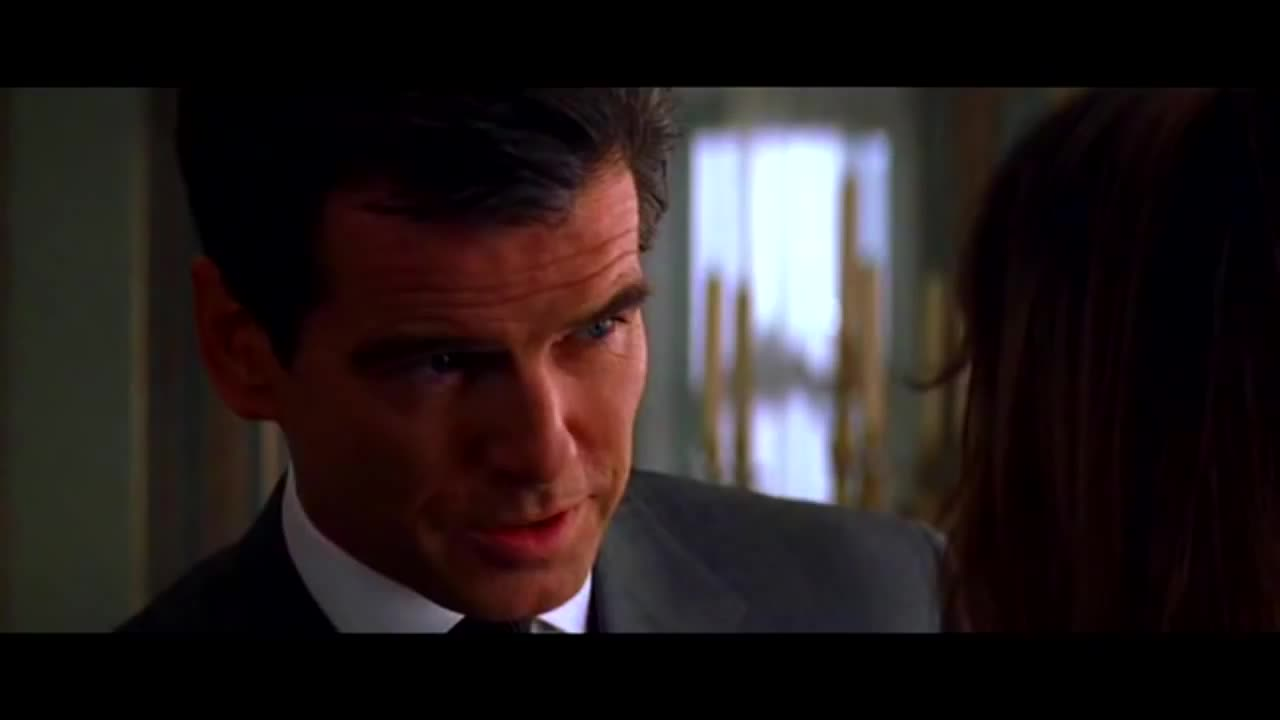

Rank 12, region


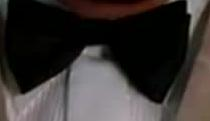

Rank 13, region


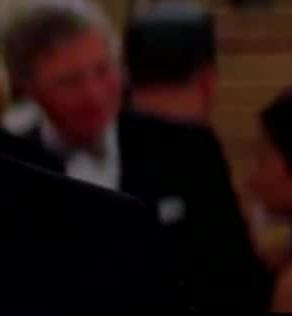

Rank 14, region


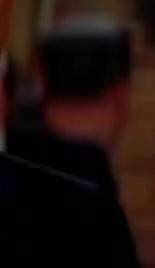

Rank 15, region


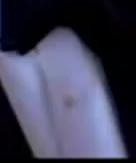

Rank 16, full frame


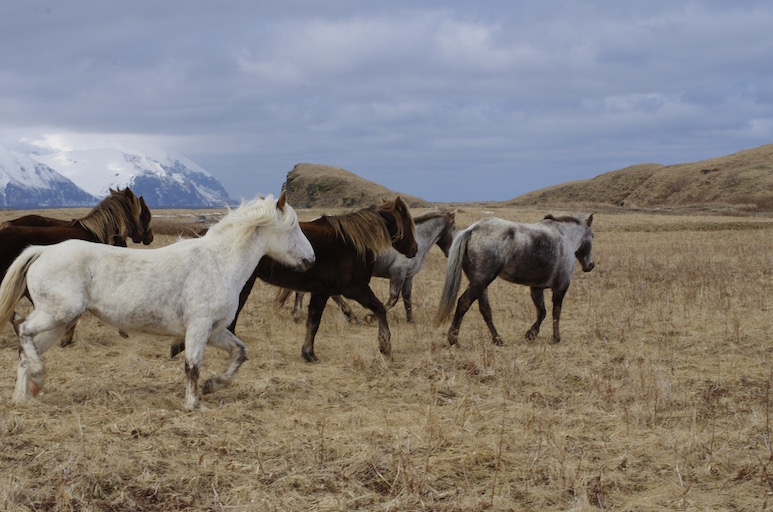

Rank 17, full frame


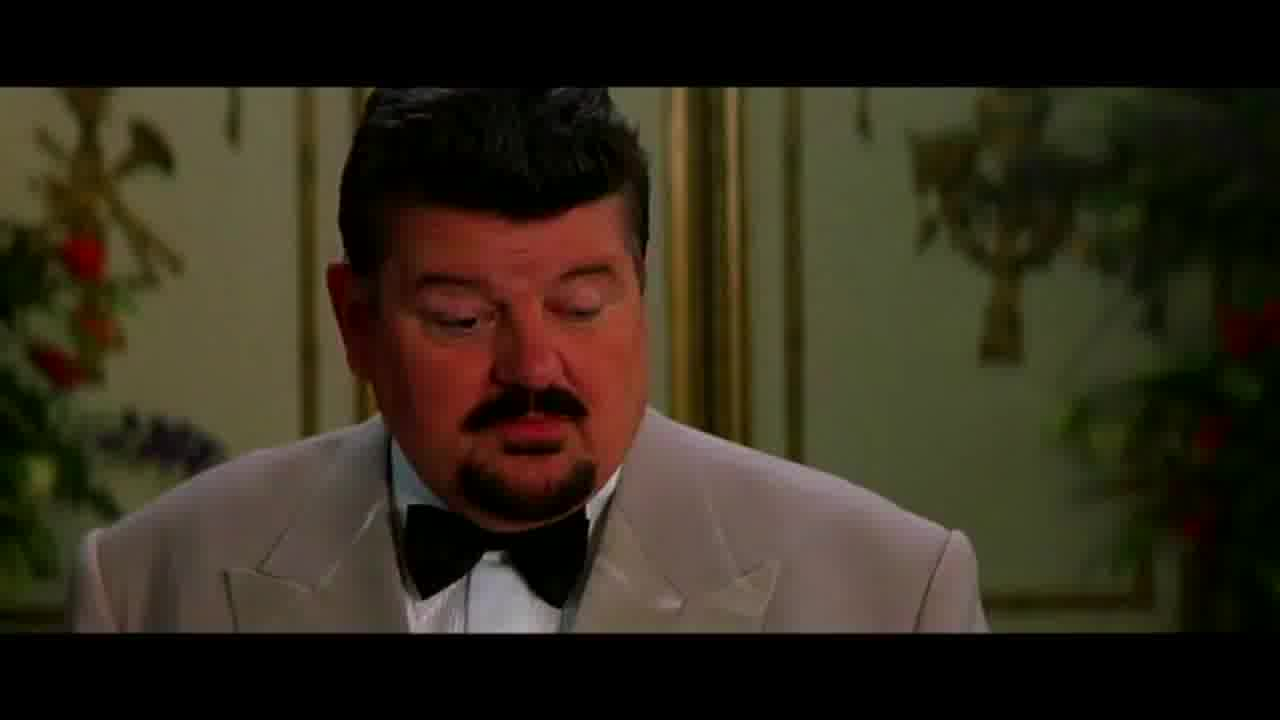

Rank 18, region


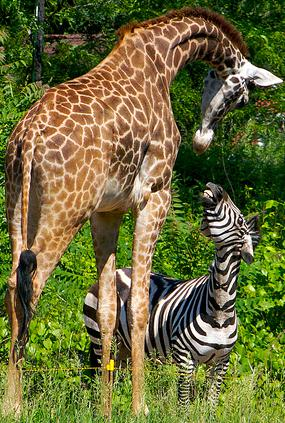

Rank 19, region


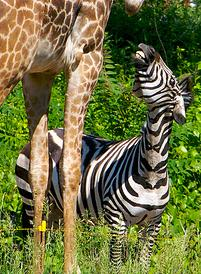

Rank 20, region


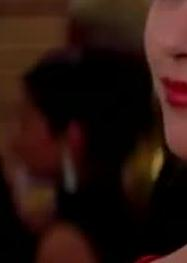

In [11]:
for r in q.search_results:
    r.visualize()

In [ ]:
q = dvaclient.query.FindSimilarImages('figures/query_car.png',indexer_pk=inception_indexer_pk,retriever_pk=inception_retriever_pk)
q.execute(context=ctx)
q.wait()
q.gather_search_results()
for r in q.search_results:
    r.visualize()